# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


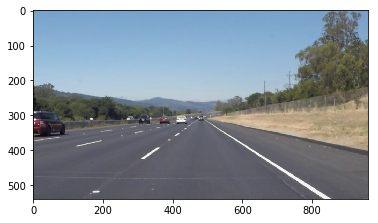

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [101]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_extrapolated_lines(image, lines, color=[255, 0, 0], thickness=15):
    x_array = np.array([])
    y_array = np.array([])
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            x_array= np.append(x_array, [x1, x2])
            y_array =np.append(y_array, [y1, y2])

    coefficients = np.polyfit(x_array, y_array, 1)
    
    f = np.poly1d(coefficients)
    #for i in np.arange(int(min(x_array)), int(max(x_array)) - 10, 10):
    #    cv2.line(image, (i, int(f(i))), (i + 10, int(f(i + 10))), color, thickness)
    
    print(int(min(x_array)), int(f(min(x_array))))
    print(int(max(x_array)), int(f(max(x_array))))
    
    cv2.line(image,(int(min(x_array)), int(f(min(x_array)))),(int(max(x_array)), int(f(max(x_array)))), color, thickness)

    
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_extrapolated_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [15]:
import os
test_images = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

280 465
459 326
310 428
456 323
154 545
447 333
175 531
456 326
138 545
436 338
195 532
468 322


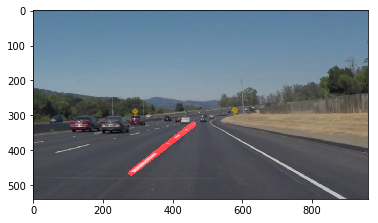

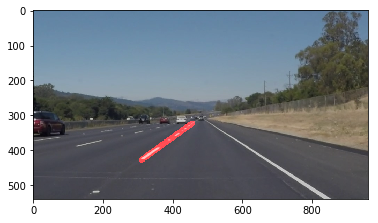

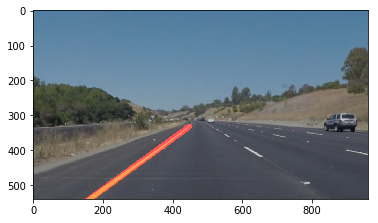

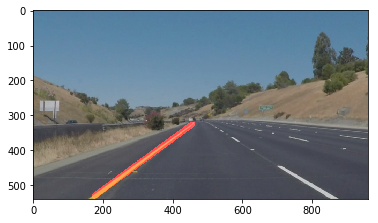

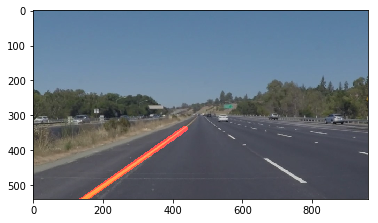

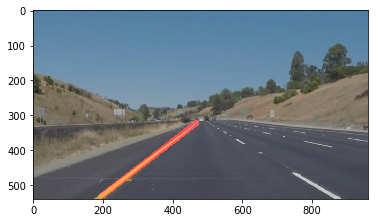

In [102]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

GAUSSIAN_KERNEL_SIZE = 5
CANNY_LOW_THRESHOLD = 50
CANNY_HIGH_THRESHOLD = 150

HOUGH_RHO = 2 # distance resolution in pixels of the Hough grid
HOUGH_THETA = np.pi/180 # angular resolution in radians of the Hough grid
HOUGH_THRESHOLD = 15     # minimum number of votes (intersections in Hough grid cell)
HOUGH_MIN_LINE_LENGTH = 40 #minimum number of pixels making up a line
HOUGH_MAX_LINE_GAP = 20    # maximum gap in pixels between connectable line segments

def show(images):
    for image in images:
        # plt.imshow(image)
        plt.imshow(image, cmap='Greys_r')
        plt.show()
    
def load_image(image_file):
    image = mpimg.imread('test_images/' + image_file)

    return image

def save_image(image, name):
    mpimg.imsave('test_images/processed-' + name, image)
    
def go_go_gadget(original_image):
    shape = original_image.shape
    
    #vertices = np.array([[
    #    (100, shape[0]),(450, 325),
    #    (490, 325), (shape[1], shape[0])
    #]], dtype=np.int32)
    
    vertices = np.array([[
        (100, shape[0]),(450, 325),
        (490, 325), (shape[1]/2, shape[0])
    ]], dtype=np.int32)
    
    image = grayscale(original_image)
    image = gaussian_blur(image, GAUSSIAN_KERNEL_SIZE)
    image = canny(image, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    image = region_of_interest(image, vertices)
    image = hough_lines(image, HOUGH_RHO, HOUGH_THETA, HOUGH_THRESHOLD, HOUGH_MIN_LINE_LENGTH, HOUGH_MAX_LINE_GAP)
    image = weighted_img(image, original_image)
    
    return image
    
images = [load_image(image) for image in test_images]
images = [go_go_gadget(image) for image in images]

[save_image(image, name) for image, name in zip(images, test_images)]

show(images)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [51]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = go_go_gadget(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [99]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

blah
188 516
450 325
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 5/222 [00:00<00:04, 48.43it/s]

blah
188 516
450 325
blah
150 540
455 322
blah
150 546
455 322
blah
148 545
455 322
blah
360 389
454 323
blah
360 391
450 322
blah
352 396
454 323
blah
326 412
453 323
blah
310 425
454 323


  5%|▍         | 11/222 [00:00<00:04, 49.60it/s]

blah
297 436
456 323
blah
268 460
458 324


  7%|▋         | 16/222 [00:00<00:04, 48.35it/s]

blah
230 486
460 323
blah
183 519
458 322
blah
145 542
455 324
blah
142 543
451 324
blah
138 545
450 325
blah
360 387
450 325
blah
350 394
450 324
blah
346 400
450 325


 11%|█         | 24/222 [00:00<00:04, 41.65it/s]

blah
392 368
455 322
blah
310 426
457 323
blah
289 441
457 323
blah
264 459
456 324
blah
232 481
455 324
blah
186 514
451 326
blah
141 546
453 324
blah

 14%|█▍        | 32/222 [00:00<00:05, 34.86it/s]


142 546
455 323
blah
142 548
455 323
blah
362 391
455 323
blah
352 397
453 323
blah
348 401
453 322
blah
393 366
453 322
blah
311 424
452 324
blah
292 439
448 326


 19%|█▉        | 42/222 [00:01<00:04, 38.80it/s]

blah
269 457
454 323
blah
236 481
455 322
blah
192 512
455 323
blah
146 544
455 322
blah
145 547
454 323
blah
143 549
454 322
blah
363 388
452 323
blah
354 394
451 323
blah
343 401
452 324
blah
391 365
450 324


 21%|██        | 47/222 [00:01<00:05, 32.84it/s]

blah
313 422
451 324
blah
295 435
450 324
blah
270 452
447 326
blah
252 463
446 327


 23%|██▎       | 51/222 [00:01<00:05, 29.39it/s]

blah
197 506
453 322
blah
140 546
451 324
blah
139 543
452 323
blah
137 545
449 324
blah
359 385
452 323


 25%|██▍       | 55/222 [00:01<00:07, 23.36it/s]

blah
348 393
452 323
blah
394 363
451 324
blah
389 367
453 324


 26%|██▌       | 58/222 [00:01<00:06, 23.74it/s]

blah
306 420
454 324
blah
286 440
456 321


 27%|██▋       | 61/222 [00:01<00:06, 24.48it/s]

blah
260 456
450 326
blah
226 478
455 323
blah
181 508
454 323
blah
132 546
455 321


 29%|██▉       | 64/222 [00:02<00:06, 23.84it/s]

blah
135 542
455 323
blah
131 544
455 323


 31%|███       | 68/222 [00:02<00:05, 25.92it/s]

blah
357 388
455 323
blah
347 393
454 324
blah
342 398
450 324
blah
391 366
447 326
blah

 32%|███▏      | 71/222 [00:02<00:05, 26.43it/s]


306 420
451 324
blah
286 434
453 323
blah
261 453
450 324


 33%|███▎      | 74/222 [00:02<00:05, 26.25it/s]

blah
230 472
451 324
blah
187 502
452 324
blah
127 542
451 324


 35%|███▌      | 78/222 [00:02<00:05, 27.65it/s]

blah
123 541
450 326
blah
120 544
448 325
blah
119 539
451 325
blah
345 392
448 326
blah
390 364
450 326
blah
388 365
446 327


 38%|███▊      | 84/222 [00:02<00:05, 26.64it/s]

blah
302 420
444 329
blah
282 433
444 329
blah
257 450
450 324
blah
225 471
451 325
blah
183 497
451 325
blah
122 539
451 324


 39%|███▉      | 87/222 [00:02<00:05, 24.27it/s]

blah
117 547
452 324
blah
118 544
450 325
blah
118 538
452 325


 41%|████      | 90/222 [00:03<00:05, 23.37it/s]

blah
352 390
453 324
blah
391 363
455 323
blah
387 368
455 324


 42%|████▏     | 94/222 [00:03<00:05, 24.41it/s]

blah
305 421
455 323
blah
286 434
454 323
blah
261 448
455 323
blah
231 470
448 327
blah
190 497
454 323
blah

 44%|████▍     | 98/222 [00:03<00:04, 25.39it/s]


132 533
454 324
blah
117 545
453 323


 45%|████▌     | 101/222 [00:03<00:05, 21.62it/s]

blah
117 544
445 328
blah
117 543
451 326


 47%|████▋     | 104/222 [00:03<00:05, 21.01it/s]

blah
350 394
455 322
blah
340 402
458 322
blah
326 409
459 323


 48%|████▊     | 107/222 [00:03<00:05, 22.63it/s]

blah
311 422
452 326
blah
292 433
457 322
blah
268 450
456 322
blah
245 466
454 323


 50%|████▉     | 110/222 [00:03<00:05, 20.15it/s]

blah
197 499
453 324
blah
142 537
452 325
blah
132 542
457 323
blah
133 542
456 323
blah
133 538
454 325


 52%|█████▏    | 116/222 [00:04<00:04, 22.06it/s]

blah
353 391
457 323
blah
354 392
453 324
blah
393 364
452 325
blah
314 417
457 323


 54%|█████▎    | 119/222 [00:04<00:04, 22.96it/s]

blah
296 429
458 322
blah
274 442
458 322


 55%|█████▍    | 122/222 [00:04<00:04, 22.87it/s]

blah
244 467
458 323
blah
216 487
459 322
blah
152 528
456 326


 56%|█████▋    | 125/222 [00:04<00:04, 23.41it/s]

blah
132 541
460 323
blah
131 543
460 323
blah
150 536
459 323


 58%|█████▊    | 128/222 [00:04<00:03, 24.51it/s]

blah
356 394
459 322
blah
347 399
460 323
blah
396 366
460 322
blah
320 420
459 323
blah
302 432
461 323


 59%|█████▉    | 131/222 [00:04<00:03, 23.48it/s]

blah
280 449
461 322
blah
252 471
462 322
blah
215 497
461 323


 60%|██████    | 134/222 [00:04<00:03, 22.62it/s]

blah
163 532
454 326
blah
146 544
454 325


 62%|██████▏   | 137/222 [00:05<00:03, 23.26it/s]

blah
141 543
455 323
blah
141 545
456 322
blah
360 390
455 323


 63%|██████▎   | 140/222 [00:05<00:03, 22.02it/s]

blah
350 397
458 322
blah
377 381
458 322


 64%|██████▍   | 143/222 [00:05<00:03, 23.93it/s]

blah
325 417
460 323
blah
307 430
461 323
blah
286 450
460 324
blah
259 467
460 324
blah
223 493
459 326


 66%|██████▌   | 146/222 [00:05<00:03, 22.30it/s]

blah
175 528
460 324
blah
153 544
459 322
blah
152 541
457 324


 67%|██████▋   | 149/222 [00:05<00:03, 22.88it/s]

blah
151 545
456 325
blah
363 392
458 323
blah
353 401
459 324
blah
401 365
461 323
blah

 69%|██████▉   | 153/222 [00:05<00:02, 24.43it/s]


328 416
461 323
blah
311 430
460 323
blah
289 448
459 322
blah
262 465
459 323


 71%|███████   | 157/222 [00:05<00:02, 25.30it/s]

blah
227 491
459 323
blah
178 528
458 323
blah
156 542
459 323


 72%|███████▏  | 160/222 [00:06<00:02, 25.23it/s]

blah
158 544
460 322
blah
159 545
460 324


 73%|███████▎  | 163/222 [00:06<00:02, 22.28it/s]

blah
370 391
461 325
blah
360 397
457 325


 75%|███████▍  | 166/222 [00:06<00:02, 22.22it/s]

blah
404 364
462 322
blah
336 415
462 323
blah
321 429
462 323
blah
301 446
463 323
blah
275 466
462 324
blah

 77%|███████▋  | 172/222 [00:06<00:02, 24.98it/s]


242 492
461 323
blah
196 527
461 323
blah
175 545
460 324
blah
178 543
462 323


 79%|███████▉  | 175/222 [00:06<00:01, 25.86it/s]

blah
175 547
461 322
blah
373 391
456 325
blah
364 397
460 322
blah
353 407
462 321


 80%|████████  | 178/222 [00:06<00:01, 25.08it/s]

blah
350 413
458 324
blah
325 429
462 322


 82%|████████▏ | 181/222 [00:06<00:01, 23.96it/s]

blah
307 444
461 322
blah
282 462
459 324
blah
251 492
460 322
blah

 83%|████████▎ | 184/222 [00:07<00:01, 19.93it/s]


207 525
461 322
blah
181 548
460 322
blah
180 545
460 322
blah
179 546
459 323
blah
373 390
459 322


 86%|████████▌ | 190/222 [00:07<00:01, 21.90it/s]

blah
364 399
459 321
blah
377 384
457 322
blah
401 365
454 323
blah
325 420
453 324
blah
306 443
452 325
blah
281 461
458 321


 88%|████████▊ | 196/222 [00:07<00:01, 20.98it/s]

blah
250 489
460 323
blah
206 526
461 323
blah
177 544
464 321
blah
178 545
460 325
blah
178 545
457 325


 91%|█████████ | 202/222 [00:07<00:00, 23.34it/s]

blah
371 392
459 323
blah
363 398
460 321
blah
352 408
457 324
blah
239 508
460 321
blah
182 550
460 319
blah
305 444
461 320


 94%|█████████▎| 208/222 [00:08<00:00, 23.84it/s]

blah
280 464
457 324
blah
249 489
456 323
blah
204 522
457 324
blah
193 531
458 321
blah
176 543
455 323


 96%|█████████▋| 214/222 [00:08<00:00, 23.12it/s]

blah
178 545
456 322
blah
373 387
459 321
blah
364 397
458 322
blah
353 405
462 321
blah
356 404
463 320
blah
324 427
463 322


 99%|█████████▉| 220/222 [00:08<00:00, 24.10it/s]

blah
305 442
464 321
blah
281 466
463 323
blah
248 490
464 321
blah
203 526
462 323
blah
177 544
455 327
blah
175 545
460 324


100%|█████████▉| 221/222 [00:08<00:00, 25.33it/s]


blah
175 545
461 323
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.44 s, sys: 843 ms, total: 4.28 s
Wall time: 10.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [62]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.99 s, sys: 2.1 s, total: 11.1 s
Wall time: 22.9 s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))